最开始的部分和第一篇讲的seq2seq模型一致

In [1]:
import numpy as np
import tensorflow as tf
import helper

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
PAD = 0
EOS = 1
# UNK = 2
# GO  = 3

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [3]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')

encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [4]:
embeddings = tf.Variable(tf.truncated_normal([vocab_size, input_embedding_size], mean=0.0, stddev=0.1), dtype=tf.float32)

In [5]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

## encoder
此处定义的encoder和第一篇中的不同，需要注意

In [6]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

关于LSTMCell和 BasicLSTMCell 的区别，这个可以去tf的官网看说明：

> It(BasicLSTMCell) does not allow cell clipping, a projection layer, and does not use peep-hole connections: it is the basic baseline.

这个projection layer就是在输出ouput上加了一层fc，将其作为lstm的输出

cell clipping ?

peep-hole connections?

In [8]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

此处 encoder_cell 的形状是：[max_time, batch_size, ...]，

encoder_fw_outputs 的形状是：[max_time, batch_size, cell_fw.output_size]

sequence_length：如果没有提供，则默认长度就是 [0,max_time-1]，如果提供了则取 [0,sequence_length-1]

state 的形状是 ： [batch_size, cell_fw.state_size]

In [9]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [11]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [12]:
encoder_cell.state_size

LSTMStateTuple(c=20, h=20)

- encoder_fw_final_state.h is activations of hidden layer of LSTM cell
- encoder_fw_final_state.c is final output, which can potentially be transfromed with some wrapper 


此处 h 指的是内部的状态，而 c 则是 h 经过 activations 后的状态

In [13]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

在这个例子中，我们不会舍去 encoder_outputs，而是会将其用于attention机制
## decoder

In [14]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [15]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

下一步我们要要决定 decoder 运行多少步后结束，有两种策略

- Stop after specified number of unrolling steps
- Stop after model produced

此处我们选择第一种，固定的步骤，在之前的一些tutorial中一般是len(encoder_input)+10，此处我们测试用则简单点使用len(encoder_input)+2

In [16]:
decoder_lengths = encoder_inputs_length + 3
# +2 additional steps, +1 leading <EOS> token for decoder inputs

## Output projection
decoder的预测流程是：

> output(t) -> output projection(t) -> prediction(t) (argmax) -> input embedding(t+1) -> input(t+1)

我们先指定输出projection的W和b

In [17]:
W = tf.Variable(tf.truncated_normal([decoder_hidden_units, vocab_size], 0, 0.1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

## Decoder via tf.nn.raw_rnn
使用dynamic_rnn有一些限制，不能让我们自定义输入，像下图一样

![raw_rnn](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2016/04/nct-seq2seq.png)


图片来自： http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/

In [18]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

对于标准的 tf.nn.dynamic_rnn ，其输入 (t, ..., t+n) 需要事先作为一个 Tensor 输入，其动态 "Dynamic" 的含义是 n 的大小在每个batch中可以改变

此时如果我们希望一些更加复杂的机制，如每个cell的输出作为下一个的输入，或者实现 soft attention ，就没有办法了，这个时候我们就转向 tf.nn.raw_rnn 函数了

tf.nn.raw_rnn 最重要的就是 loop_fn 函数的编写，loop_fn做了一个映射

> (time, previous_cell_output, previous_cell_state, previous_loop_state) -> (elements_finished, input, cell_state, output, loop_state).

上面转换的时机是在调用rnncell之前，准备好输入

loop_fn调用的时机有2个：
1. Initial call at time=0 to provide initial cell_state and input to RNN.
2. Transition call for all following timesteps where you define transition between two adjacent steps.

下面分别定义

In [19]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [20]:
# (time, previous_cell_output, previous_cell_state, previous_loop_state) -> 
#     (elements_finished, input, cell_state, output, loop_state).
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b) # projection layer
        # [batch_size, vocab_size]
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        # [batch_size, input_embedding_size]
        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    # input shape [batch_size,input_embedding_size]
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

上面我们分别定义了两个loop_fn，下面我们会将其合并为一个

In [21]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [22]:
decoder_outputs # hidden_size = 40

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

为了对输出做最后的projection操作，我们需要reshape操作

[max_steps, batch_size, hidden_dim] to [max_steps*batch_size, hidden_dim]



In [23]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [24]:
decoder_prediction = tf.argmax(decoder_logits, 2)

## Optimizer
rnn的输出shape是：[max_time, batch_size, hidden_units]， 通过一个FC（projection layer）变换为[max_time, batch_size, vocab_size]，vocab_size是固定的，max_time and batch_size 是动态的

In [25]:
print(decoder_targets)

Tensor("decoder_targets:0", shape=(?, ?), dtype=int32)


In [27]:
print(tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32))

Tensor("one_hot:0", shape=(?, ?, 10), dtype=float32)


In [28]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [29]:
sess.run(tf.global_variables_initializer())

## 模型训练
跟第一篇中的训练一致

In [31]:
batch_size = 100

batches = helper.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[3, 8, 9, 4, 9, 4]
[2, 3, 7, 2, 5, 2]
[4, 8, 8, 2]
[9, 6, 2, 5, 8, 3, 5, 3]
[9, 7, 2, 6]
[7, 6, 2]
[4, 9, 6, 6]
[8, 4, 7, 8, 9, 8, 7]
[4, 3, 6, 7, 4, 2]
[6, 5, 8]


In [32]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helper.batch(batch)
    decoder_targets_, _ = helper.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [33]:
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.3008058071136475
  sample 1:
    input     > [2 7 7 4 0 0 0 0]
    predicted > [8 8 0 0 8 0 0 0 0 0 0]
  sample 2:
    input     > [5 2 6 3 2 4 4 0]
    predicted > [8 9 9 9 9 9 9 9 9 9 0]
  sample 3:
    input     > [7 8 3 6 0 0 0 0]
    predicted > [5 1 8 1 4 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.7816314697265625
  sample 1:
    input     > [4 7 4 4 0 0 0 0]
    predicted > [4 4 4 4 1 0 0 0 0 0 0]
  sample 2:
    input     > [4 5 4 5 5 3 7 0]
    predicted > [4 5 5 5 5 5 5 1 0 0 0]
  sample 3:
    input     > [6 6 7 7 0 0 0 0]
    predicted > [6 7 7 7 1 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.37288352847099304
  sample 1:
    input     > [7 3 2 3 0 0 0 0]
    predicted > [7 3 2 3 1 0 0 0 0 0 0]
  sample 2:
    input     > [9 6 3 9 6 0 0 0]
    predicted > [9 9 6 6 6 1 0 0 0 0 0]
  sample 3:
    input     > [8 4 6 6 2 0 0 0]
    predicted > [8 4 6 6 2 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.22249329090118408
  sample 1:
    input     > [6 3

loss 0.2228 after 300100 examples (batch_size=100)


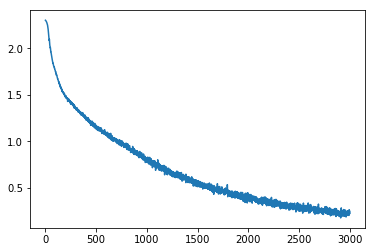

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))